# MerciPy Benchmarks

The RRT implementations in Merci are written in Rust for speed and safety. We demo some of the python bindings in this notebook and show their speed against simple, pure python versions. I admit that is not necessarily a fair comparison--some of the python implementations can be improved. We are comparing against what was used on the competition, however, and we stand to gain much speed by optimizing what we had.

In [1]:
import mercipy as mp
import numpy as np
import matplotlib.pyplot as plt

import time

## RRT Performance

We show the RRT performance against [PythonRobotics](https://github.com/AtsushiSakai/PythonRobotics). Admittedly, PythonRobotics did not implement RRT for performance, instead putting in animations and print statements to show progress. 

MerciPy RRT Time: 0.0085s
PythonRobotics RRT Time: 0.4236s
Performance Multiplier:  49.654


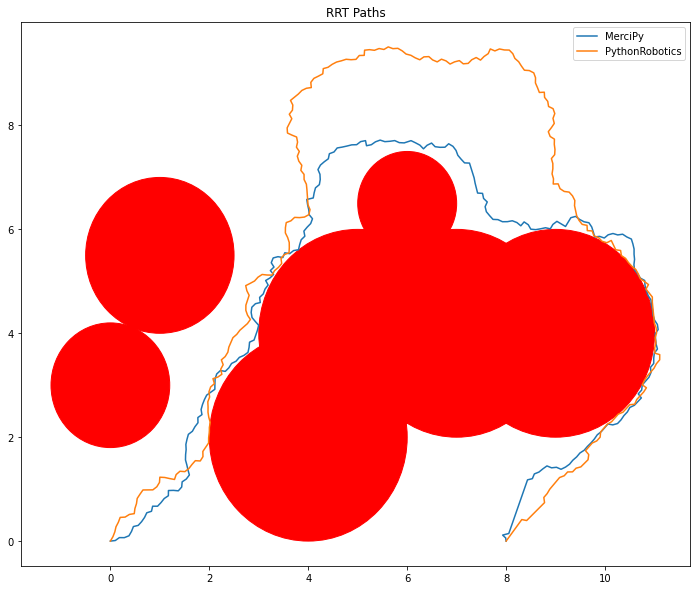

In [2]:
import sys
sys.path.append("../mercipy/")
from pythonrobotics import rrt as rrtpr
from pythonrobotics import rrtstar as rrtprs

# our benchmark scenario is a bunch of spherical obstacles (center_x, center_y, radius)
obstacles = [
    (4.0, 2.0, 2.0), 
    (5.0, 4.0, 2.0), 
    (7.0, 4.0, 2.0), 
    (9.0, 4.0, 2.0), 
    (0.0, 3.0, 1.2), 
    (1.0, 5.5, 1.5),
    (6.0, 6.5, 1.0)
]

# rrt parameters
begin = (0.0, 0.0)
goal = (8.0, 0.0)
expand_dis = 0.1
path_resolution = 0.1
goal_sample_rate = 5
max_iter = 1000000
explore_area = ((0.0, 0.0), (12.0, 10.0))

start = time.time()
res = mp.mercipy.plan_rrt(
    begin,
    goal,
    obstacles,
    expand_dis,
    path_resolution,
    goal_sample_rate,
    max_iter,
    explore_area
)
end = time.time()
mercipy_time = end-start
print(f"MerciPy RRT Time: {mercipy_time:1.4f}s")

rrt = rrtpr.RRT(
    begin,
    goal,
    obstacles,
    (0.0, 12.0),
    expand_dis,
    path_resolution,
    goal_sample_rate,
    max_iter,
    [explore_area[0][0], explore_area[1][0], explore_area[0][1], explore_area[1][1]],
)

start = time.time()
res_pr = rrt.planning(animation=False)
end = time.time()
pr_time = end-start
print(f"PythonRobotics RRT Time: {pr_time:1.4f}s")


print(f"Performance Multiplier: {pr_time / mercipy_time: 2.3f}")


# plot
plt.figure(figsize=(12, 10))
plt.plot(*np.array(res).T, label="MerciPy")
plt.plot(*np.array(res_pr).T, label="PythonRobotics")
plt.title("RRT Paths")
plt.legend()

for obs in obstacles:
    circle1 = plt.Circle(obs[:-1], obs[-1], color='r')
    plt.gca().add_patch(circle1)

In [8]:
import tqdm
from joblib import Parallel, delayed


results = Parallel(n_jobs=32)(delayed(mp.mercipy.plan_rrt)(begin,
        goal,
        obstacles,
        expand_dis,
        path_resolution,
        goal_sample_rate,
        max_iter,
        explore_area) for i in tqdm.tqdm(range(10000)))


100%|███████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 17093.84it/s]


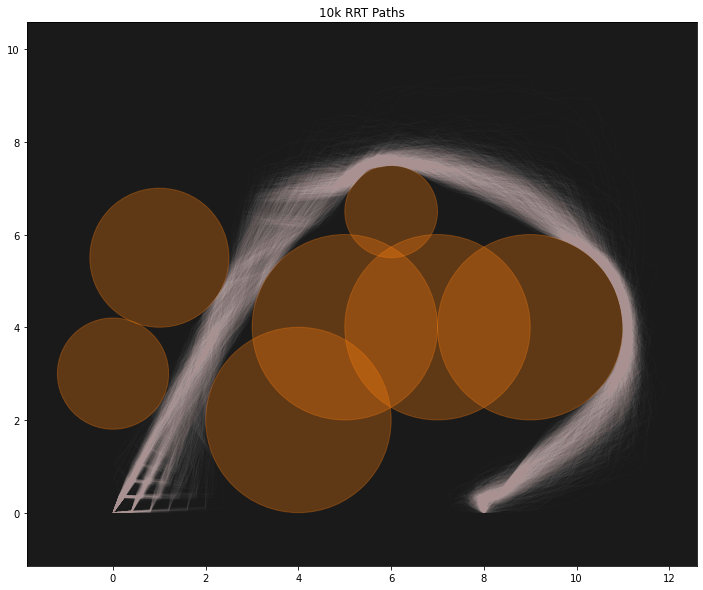

In [9]:
plt.figure(figsize=(12, 10))
    
for res in results:
    if res is None or len(res) == 0:
        continue
    plt.plot(*np.array(res).T, color=(1.0, 0.9, 0.9), alpha=0.01)
    
for obs in obstacles:
    circle1 = plt.Circle(obs[:-1], obs[-1], color='C1', alpha=0.3)
    plt.gca().add_patch(circle1)
plt.axis("equal")
plt.gca().set_facecolor((0.1, 0.1, 0.1))
plt.title("10k RRT Paths")
plt.show()

## RRT* Performance

MerciPy RRT* Time: 0.0231s
PythonRobotics RRT* Time: 4.8834s
Performance Multiplier:  211.014


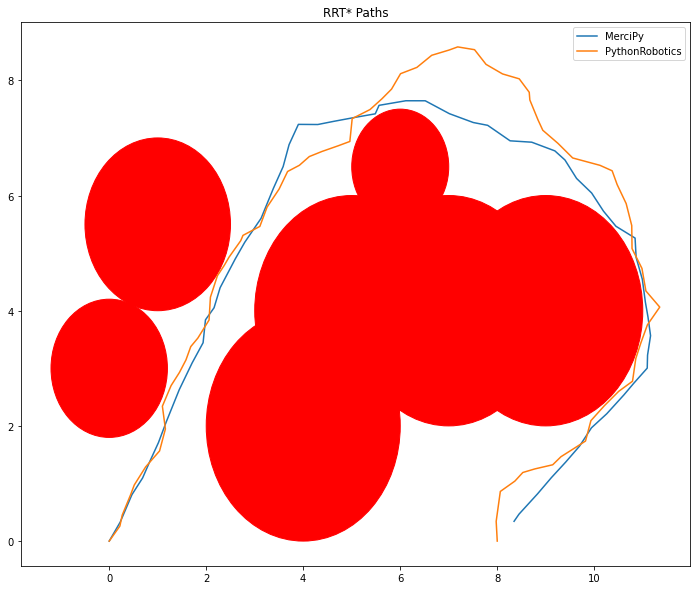

In [17]:
path_resolution = 0.4
expand_dis = 0.4
max_iter = 3000
goal_sample_rate = 0
connect_circle_dist = 100.0
search_until_max = True

start = time.time()
res = mp.mercipy.plan_rrtstar(
    begin,
    goal,
    obstacles,
    expand_dis,
    path_resolution,
    goal_sample_rate,
    max_iter,
    explore_area,
    connect_circle_dist,
    search_until_max
)
end = time.time()
mercipy_time = end-start
print(f"MerciPy RRT* Time: {mercipy_time:1.4f}s")


start = time.time()
rrt = rrtprs.RRTStar(
    begin,
    goal,
    obstacles,
    (0.0, 12.0),
    expand_dis,
    path_resolution,
    goal_sample_rate,
    max_iter,
    #[explore_area[0][0], explore_area[1][0], explore_area[0][1], explore_area[1][1]],
    connect_circle_dist, 
    search_until_max
)
res_pr = rrt.planning(animation=False)
end = time.time()
pr_time = end-start
print(f"PythonRobotics RRT* Time: {pr_time:1.4f}s")

print(f"Performance Multiplier: {pr_time / mercipy_time: 2.3f}")

# plot
plt.figure(figsize=(12, 10))
plt.plot(*np.array(res).T, label="MerciPy")
plt.plot(*np.array(res_pr).T, label="PythonRobotics")
plt.title("RRT* Paths")
plt.legend()

for obs in obstacles:
    circle1 = plt.Circle(obs[:-1], obs[-1], color='r')
    plt.gca().add_patch(circle1)

## Obstacles Performance

Obstacles are important for sampler-based, obstacle aware path planning. We show that MerciPy uses efficient implementations of several collider types, some of which is taken from [ncollide2d](https://docs.rs/ncollide2d/latest/ncollide2d/). 

In [10]:
class MyCircleBounds:
    """let's write a circle collider in pure python to compare against the Merci Rust version"""
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
        
    def is_collision(self, pts):
        """for a list of points, determine if they fall in the circle boundary"""
        # we avoid a sqrt for performance. What else can we do?
        return [
            ((pt[0]-self.x)** + (pt[0]-self.y)**2) < self.r**2 for pt in pts
        ]

In [11]:
# let's instantiate the mercipy collider and ours
c = mp.CircleBounds(-.3, .2, 1.2)
my_c = MyCircleBounds(-.3, .2, 1.2)

# generate points to test
pts = np.random.random(size=(1000000, 2)).tolist()
# ew, we need to make a list of tuples :/ TODO: numpy.ndarray?
pts = [tuple(p) for p in pts]

# now run the benchmark
s = time.time()
dc = c.is_collision(pts)
e = time.time()
mp_time = e - s
print(f"Mercipy Time: {e - s:1.4f}s")

s = time.time()
my_dc = my_c.is_collision(pts)
e = time.time()
o_time = e - s
print(f"My Time: {e - s:1.4f}")

print(f"Performance Multiplier: {o_time / mp_time:1.4f}")

Mercipy Time: 0.0424s
My Time: 0.2092
Performance Multiplier: 4.9384


In [ ]:
# the circle collider plot
plt.figure(figsize=(10, 10))
plt.scatter(*np.array(pts)[np.array(dc)].T, s=1, alpha=0.5, label="in")
plt.scatter(*np.array(pts)[np.logical_not(np.array(dc))].T, s=1, alpha=0.5, label="out")
plt.legend(loc="upper left")
plt.title("Circle Collider Plot")
plt.show()

In [ ]:
# let's show a more demanding obstacle type
c = mp.mercipy.ConvexPolygonBounds([(0.2, 0.1), (0.6, 0.6), (0.8, 0.2), (0.0, 0.8)])
s = time.time()
dc = c.is_collision(pts)
e = time.time()
print(f"ConvexPolygon Time: {e - s:1.4f}s")

plt.figure(figsize=(10, 10))
plt.scatter(*np.array(pts)[np.array(dc)].T, s=1, alpha=0.5)
plt.scatter(*np.array(pts)[np.logical_not(np.array(dc))].T, s=1, alpha=0.5)
plt.title("ConvexPolygon Collider Plot")
plt.show()